In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from data_reader import read_consumption_and_weather
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [3]:
def preprocess():
    df = read_consumption_and_weather()[-1]

    df_no1 = df['NO1']
    df_no1.loc[:,'region'] = 1

    df_no2 = df['NO2']
    df_no2.loc[:,'region'] = 2

    df_no3 = df['NO3']
    df_no3.loc[:,'region'] = 3

    df_no4 = df['NO4']
    df_no4.loc[:,'region'] = 4

    df_no5 = df['NO5']
    df_no5.loc[:,'region'] = 5

    # combine all dataframes into one
    df = pd.concat([df_no1, df_no2, df_no3, df_no4, df_no5])


    # datetime features
    dates = df.index
    df['time_of_day'] = df.index.hour
    df['time_of_week'] = df.index.dayofweek
    df['time_of_month'] = df.index.day
    df['time_of_year'] = df.index.month


    df['consumption_24h_lag'] = df['consumption'].shift(24)#fillna(method='bfill')
    df = df.dropna()
    df['consumption_yday_mean'] = df['consumption'].shift(24).rolling(24).mean()#fillna(method='bfill')
    df = df.dropna()
    #df['consumption_prev'] = df['consumption'].shift(1)#fillna(method='bfill')
    df = df.dropna()

    df = df[['temperature', 'consumption', 'consumption_24h_lag', 'region', 'time_of_day', 'time_of_week', 'time_of_year', 'consumption_yday_mean']]

    target_feature = 'consumption'
    #features = list(df.columns.difference([target_feature])) #kanskje bruk denne istedenfor
    features = list(df.columns)
    print("features: ", len(features))
    forecast_lead = 1
    target = f"{target_feature}_lead{forecast_lead}"

    df[target] = df[target_feature].shift(-forecast_lead)
    df = df.iloc[:-forecast_lead]
    
    return df, target, features

In [4]:
# df = read_consumption_and_weather()[-1]

# df_no1 = df['NO1']
# df_no1.loc[:,'region'] = 1

# df_no2 = df['NO2']
# df_no2.loc[:,'region'] = 2

# df_no3 = df['NO3']
# df_no3.loc[:,'region'] = 3

# df_no4 = df['NO4']
# df_no4.loc[:,'region'] = 4

# df_no5 = df['NO5']
# df_no5.loc[:,'region'] = 5

# # combine all dataframes into one
# df = pd.concat([df_no1, df_no2, df_no3, df_no4, df_no5])


# # datetime features
# dates = df.index
# df['time_of_day'] = df.index.hour
# df['time_of_week'] = df.index.dayofweek
# df['time_of_month'] = df.index.day
# df['time_of_year'] = df.index.month


# df['consumption_24h_lag'] = df['consumption'].shift(24)#fillna(method='bfill')
# df = df.dropna()
# df['consumption_yday_mean'] = df['consumption'].shift(24).rolling(24).mean()#fillna(method='bfill')
# df = df.dropna()
# df['consumption_prev'] = df['consumption'].shift(1)#fillna(method='bfill')
# df = df.dropna()
# df.head()


In [5]:
# scaler = MinMaxScaler(feature_range=(-1, 1))
# # scale temperature and consumption
# df[['temperature', 'consumption', 'consumption_24h_lag', 'consumption_yday_mean', 'consumption_prev']] = \
#     scaler.fit_transform(df[['temperature', 'consumption', 'consumption_24h_lag', 'consumption_yday_mean', 'consumption_prev']])
# df.head()

In [6]:
def plot_losses(tr, va):
  import matplotlib.pyplot as plt
  fig, ax = plt.subplots()
  ax.plot(tr, label='train')
  ax.plot(va, label='validation')
  plt.show()

In [7]:
# df = df[['temperature', 'consumption', 'consumption_24h_lag', 'region', 'time_of_day', 'time_of_week', 'time_of_year', 'consumption_yday_mean']]
# #df = df[['temperature', 'consumption']]
# df.head()

In [8]:
# target_feature = 'consumption'
# #features = list(df.columns.difference([target_feature])) #kanskje bruk denne istedenfor
# features = list(df.columns)
# print("features: ", len(features))
# forecast_lead = 1
# target = f"{target_feature}_lead{forecast_lead}"

# df[target] = df[target_feature].shift(-forecast_lead)
# df = df.iloc[:-forecast_lead]

# df.tail()

In [9]:
df, target, features = preprocess()

Holes by length and occurrences in column NO3:
Filling holes up to length 3
Any remaining holes after interpolation? False
features:  8


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [10]:
validation_start = "2022-01-01"
test_start = "2022-06-20"

df_train = df.loc[:validation_start].copy()
df_val = df.loc[validation_start:test_start].copy()
df_test = df.loc[test_start:].copy()

print("Test set fraction:", len(df_test) / len(df))

Test set fraction: 0.10327611488317236


In [11]:
# scale
mean = df_train.mean()
std = df_train.std()

def scale(df, mean, std):
  df[['temperature', 'consumption', 'consumption_24h_lag', 'consumption_yday_mean', 'consumption_lead1']] = \
    (df[['temperature', 'consumption', 'consumption_24h_lag', 'consumption_yday_mean', 'consumption_lead1']]\
      -mean[['temperature', 'consumption', 'consumption_24h_lag', 'consumption_yday_mean', 'consumption_lead1']])\
        /std[['temperature', 'consumption', 'consumption_24h_lag', 'consumption_yday_mean', 'consumption_lead1']]
  return df

df_train = scale(df_train, mean, std)
df_val = scale(df_val, mean, std)
df_test = scale(df_test, mean, std)



In [12]:
df_train.tail()

,temperature,consumption,consumption_24h_lag,region,time_of_day,time_of_week,time_of_year,consumption_yday_mean,consumption_lead1
2022-01-01 19:00:00+00:00,0.176706,-0.812833,-0.848767,5,19,5,1,-0.853229,-0.849998
2022-01-01 20:00:00+00:00,0.203883,-0.849985,-0.877159,5,20,5,1,-0.856582,-0.882539
2022-01-01 21:00:00+00:00,0.231059,-0.882526,-0.898119,5,21,5,1,-0.859169,-0.920161
2022-01-01 22:00:00+00:00,0.258236,-0.920149,-0.918242,5,22,5,1,-0.860708,-0.952852
2022-01-01 23:00:00+00:00,0.299000,-0.952839,-0.931685,5,23,5,1,-0.861172,-0.983324


In [13]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=24):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.Tensor(dataframe[target].values).float()
        self.X = torch.Tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        if idx >= self.sequence_length - 1:
            i_start = idx - self.sequence_length + 1
            x = self.X[i_start:(idx + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - idx - 1, 1)
            x = self.X[0:(idx + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[idx]

In [14]:
torch.manual_seed(42)

batch_size = 32
sequence_length = 24

train_dataset = SequenceDataset(
    df_train, 
    target = target, 
    features = features, 
    sequence_length=sequence_length
)

val_dataset = SequenceDataset(
    df_val,
    target = target,
    features = features,
    sequence_length=sequence_length
)

test_dataset = SequenceDataset(
    df_test,
    target = target,
    features = features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))
print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: torch.Size([32, 24, 8])
Target shape: torch.Size([32])


In [15]:
class CNNModel(nn.Module):
    def __init__(self, tw, num_features, use_cuda=False):
        super().__init__()
        self.tw = tw
        self.num_features = num_features

        self.feature_extractor = nn.Sequential(
            nn.Conv1d(in_channels=tw, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(32),
            nn.MaxPool1d(2, 2), # 128

            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(64),

            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(64),

            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(32),
            nn.MaxPool1d(2, 2), # 64
        )

        self.linear = nn.Sequential(
        nn.Linear(in_features=64, out_features=32),
        nn.LeakyReLU(0.2),
        nn.Linear(in_features=32, out_features=1)
        )

        if use_cuda:
            self.to(device = torch.device('cuda'))


    def forward(self, x):
        batch_size = x.shape[0]
        x = self.feature_extractor(x)
        x = x.view(batch_size, -1)
        x = self.linear(x).flatten()
        return x


gpu: True


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1 - train: 0.015137913049547933, valid: 0.006717991640187823
2 - train: 0.0046448040401537586, valid: 0.008694456386847009
3 - train: 0.0031900829487585725, valid: 0.007353745870918871
4 - train: 0.0025646474446057253, valid: 0.011140732479069928
5 - train: 0.0022925327132907116, valid: 0.018486552645461025
6 - train: 0.0019989252021150607, valid: 0.009996131048001048
7 - train: 0.0018430966697496843, valid: 0.011430525952787646
8 - train: 0.001710552171548443, valid: 0.008332613429106841
9 - train: 0.0015750772947831137, valid: 0.004718425575240495
10 - train: 0.0015098792181061072, valid: 0.006026702174681857


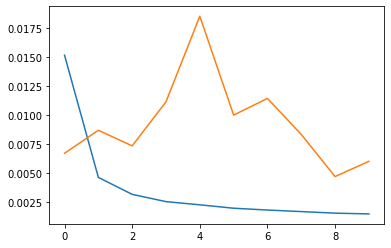

In [16]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print(f"gpu: {USE_CUDA}")
model = lr = 5e-5

model = CNNModel(tw=24, num_features=len(features), use_cuda=USE_CUDA).to(device)

lr = 4e-4
n_epochs = 10
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


t_losses, v_losses = [], []

for epoch in range(n_epochs):
    train_loss, val_loss = 0.0, 0.0

    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()

        x = x.to(device)
        y = y.squeeze().to(device)
        #print(f"x shape: {x.shape}, y shape: {y.shape}")
        #print(x)
        preds = model(x)#.squeeze()
        #print(f"preds shape: {preds.shape}")
        loss = criterion(preds, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_loss = train_loss / len(train_loader)
    t_losses.append(epoch_loss)

    # validation
    model.eval()
    for x, y in val_loader:
        with torch.no_grad():
            x = x.to(device)
            y = y.squeeze().to(device)
            preds = model(x).squeeze()
            error = criterion(preds, y)
        val_loss += error.item()
    val_loss = val_loss / len(val_loader)
    v_losses.append(val_loss)

    print(f'{epoch+1} - train: {epoch_loss}, valid: {val_loss}')

plot_losses(t_losses, v_losses)


In [17]:
torch.save(model, "./saved_models/cnn_model.pt")

In [18]:
def make_predictions_from_dataloader(model, unshuffled_dataloader):
  model.eval()
  predictions, actuals = [], []
  device = next(model.parameters()).device
  for x, y in unshuffled_dataloader:
    x = x.to(device)
    y = y.to(device)
    with torch.no_grad():
      p = model(x)
      predictions.append(p)
      actuals.append(y.squeeze())
  predictions = torch.cat(predictions).cpu().numpy()
  actuals = torch.cat(actuals).cpu().numpy()
  return predictions.squeeze(), actuals


In [19]:
preds, actuals = make_predictions_from_dataloader(model, test_loader)

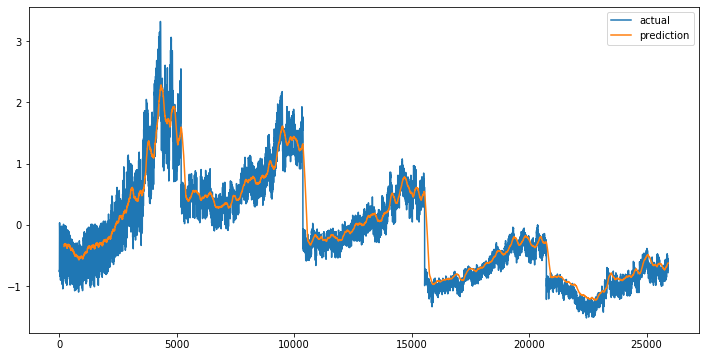

In [20]:
# plot the predictions vs the actuals witht the predictions as an average line
window_size = 200

# calculate the moving average of the predictions
moving_preds = np.convolve(preds, np.ones(window_size)/window_size, mode='valid')

# plot the actuals and smoothed predictions
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='actual')
plt.plot(np.arange(window_size-1, len(preds)), moving_preds, label='prediction')
plt.legend()
plt.show()

In [21]:
def forecast(dataloader, df_to_plot, batch_num:int=3, fw:int=24):
    """
    fw: forecast window
    """
    predictions = {i: [] for i in range(len(test_loader))}
    prev_y_ind = 1 # lag of the consumption
    df_start_ind = fw * batch_num # indexes for accessing 
    df_end_ind = fw * (batch_num + 1)
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            x, y = data
            current_input = x.to(device)
            
            for _ in range(fw):
                # Use the current input to make a prediction
                prediction = model(current_input)

                # Add the prediction to the list of predictions
                predictions[i].append(prediction.cpu().numpy())

                # delete the first timestep from the input and add the forecast to the end
                current_input[:, :-1, prev_y_ind] = current_input[:, 1:, prev_y_ind]
                current_input[:, -1, prev_y_ind] = torch.from_numpy(prediction.squeeze().cpu().numpy()).to(device) 

    targets_to_plot = df_to_plot.iloc[df_start_ind:df_end_ind]['consumption_lead1'].reset_index(drop=True)
    preds_to_plot = pd.Series(np.array(predictions[batch_num]).squeeze()[:,0])
    res_df = pd.concat([targets_to_plot, preds_to_plot], axis=1)
    res_df.rename(columns={"consumption_lead1": "target",
                           0: "pred"}, inplace=True)
    return res_df

In [22]:
def plot_forecast(test_loader, df_test, mean, std, batch_no, seq_len, fw):
    res = forecast(test_loader, df_test, batch_no, fw)
    start_ind = seq_len * batch_no
    end_ind = start_ind + seq_len + fw
    targets_to_plot = df_test.iloc[start_ind:end_ind]['consumption_lead1'].rename('target')
    preds_to_plot = res.iloc[:,1]
    last_time_ind = targets_to_plot.index[-(fw+1)]
    preds_to_plot.index = pd.date_range(start=last_time_ind, periods=fw, freq='H')
    res_df = pd.concat([targets_to_plot, preds_to_plot], axis=1)
    # unscale the data
    res_df = res_df * std['consumption_lead1'] + mean['consumption_lead1']
    # calculate the error
    res["error"] = (res["target"] - res["pred"]).abs()
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
    ax1.plot(res_df.iloc[:,0], label='actual')
    ax1.plot(res_df.iloc[:,1], label='pred')
    ax1.set_title("Forecast")
    ax2.plot(res["error"])
    ax2.set_title("absolute error")
    ax1.legend()
    plt.show()
    return res_df

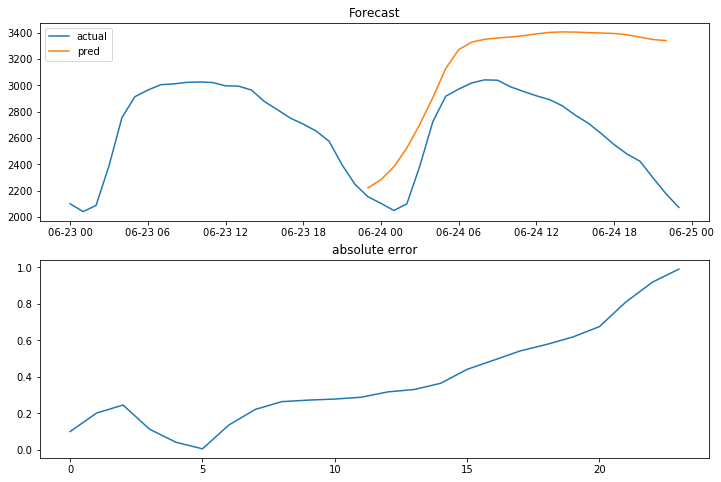

In [24]:
# prøv 3, 12, 15 
res = plot_forecast(test_loader, df_test, mean, std, 3, 24, 24)
#res = forecast(test_loader, df_test, 5, 24)